# Visualisation

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import collections

from sklearn.manifold import TSNE 

from gensim.models import Word2Vec

In [146]:
model_rise = Word2Vec.load('model_rise')
model_stable = Word2Vec.load('model_stable')
model_peak = Word2Vec.load('model_peak')

In [147]:
def fit_tsne(values):
    if not values:
        return 

    mat = np.array(values)
    model = TSNE(n_components=2, random_state=0, learning_rate=150, init='pca')
    fitted = model.fit_transform(mat)

    return fitted

In [148]:
def get_time_sims(models, word1):

    lookups = {}
    sims = {}
    for year, embed in models.items():
        for word, sim in embed.wv.most_similar(word1, topn=10):
            ww = "%s|%s" % (word, year)
            if sim > 0.3:            
                lookups[ww] = embed.wv[word]
                sims[ww] = sim

    return lookups, sims

In [154]:
def plot_words(word1, words, fitted, cmap, sims):
    # TODO: remove this and just set the plot axes directly
    plt.scatter(fitted[:,0], fitted[:,1], alpha=0)
    plt.suptitle("%s" % word1, fontsize=30, y=0.1)
    plt.axis('off')

    annotations = []

    for i in range(len(words)):
        pt = fitted[i]

        ww,decade = [w.strip() for w in words[i].split("|")]

        if ww == word1:
            annotations.append((ww, decade, pt))
            word = word1+" ("+decade+")"
            color = 'black'
            sizing = 20
            print(ww + ": annotations")
        else:
            # word1 is the word we are plotting against
            color = cmap((int(decade)-1970)/10)
            word = ww
            sizing = 15#sims[words[i]] * 30


        plt.text(pt[0], pt[1], word, color=color, size=int(sizing))

    return annotations        

def plot_annotations(annotations):
    # draw the movement between the word through the decades as a series of
    # annotations on the graph
    annotations.sort(key=lambda w: w[1], reverse=True)

    prev = annotations[0][-1]
    for ww, decade, ann in annotations[1:]:
        plt.annotate('', xy=prev, xytext=ann,
            arrowprops=dict(facecolor='grey', shrink=0.1, alpha=0.3,width=2, headwidth=10))
        prev = ann

C:\Users\evala\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\evala\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
C:\Users\evala\Anaconda3\lib\site

écologie: annotations
écologie: annotations
écologie: annotations


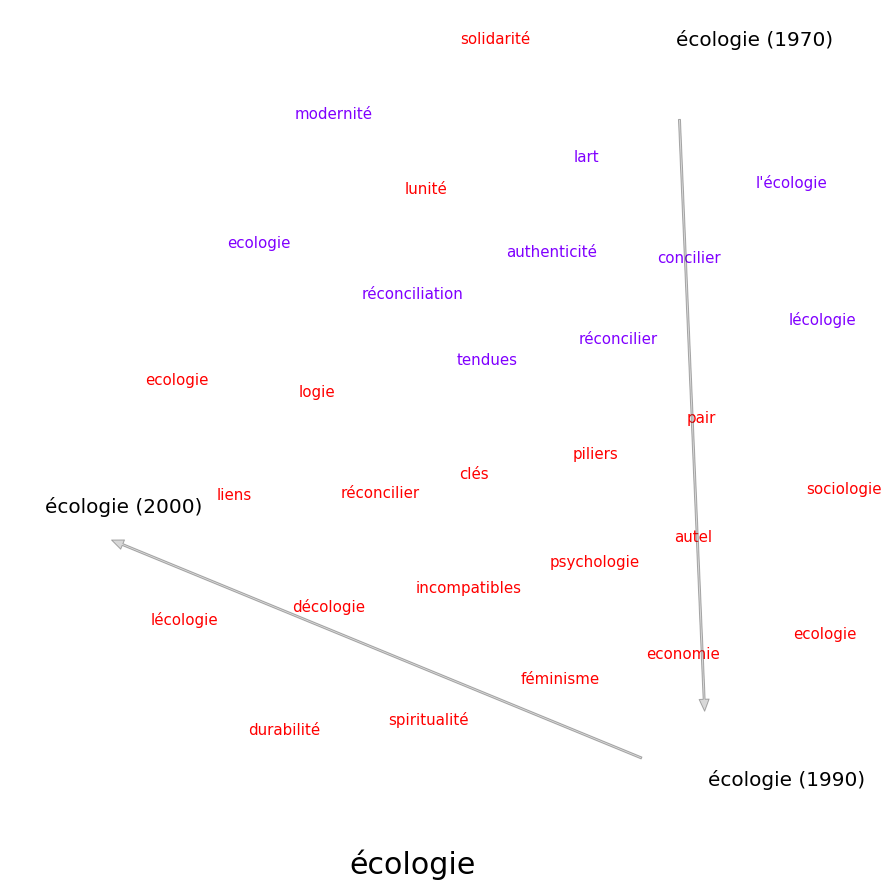

In [156]:
models = {1970: model_peak, 1990:model_rise, 2000:model_stable}
word1 = "écologie"

lookups, sims = get_time_sims(models, word1)

for decade, model in models.items():
    ww = "%s|%s" % (word1, decade)
    lookups[ww]=model.wv[word1]
    
words = list(lookups.keys())
values = [lookups[word] for word in words ]
fitted = fit_tsne(values)

cmap = plt.cm.get_cmap("rainbow", len(time_sims))

plt.figure(figsize=(15,15))

annotations = plot_words(word1, words, fitted, cmap, all_sims)
if annotations:
    plot_annotations(annotations)

plt.savefig("%s_chain.png" % word1)